<a href="https://colab.research.google.com/github/ngohiep-noob/transfer-learning-alexnet-vgg/blob/master/alexnet_vgg_tulip_daisy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment settings

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.6 MB/s eta 0:00:00


In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchmetrics.classification import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
dataset_path = '/content/drive/MyDrive/Advanced computer vision/Hiep/dataset'

# Load dataset

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_dataset = datasets.ImageFolder(root=dataset_path + '/train', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

validate_dataset = datasets.ImageFolder(root=dataset_path + '/validate', transform=transform)
validate_loader = DataLoader(dataset=validate_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder(root=dataset_path + '/test', transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

In [ ]:
classes = ["daisy", "tulip"]

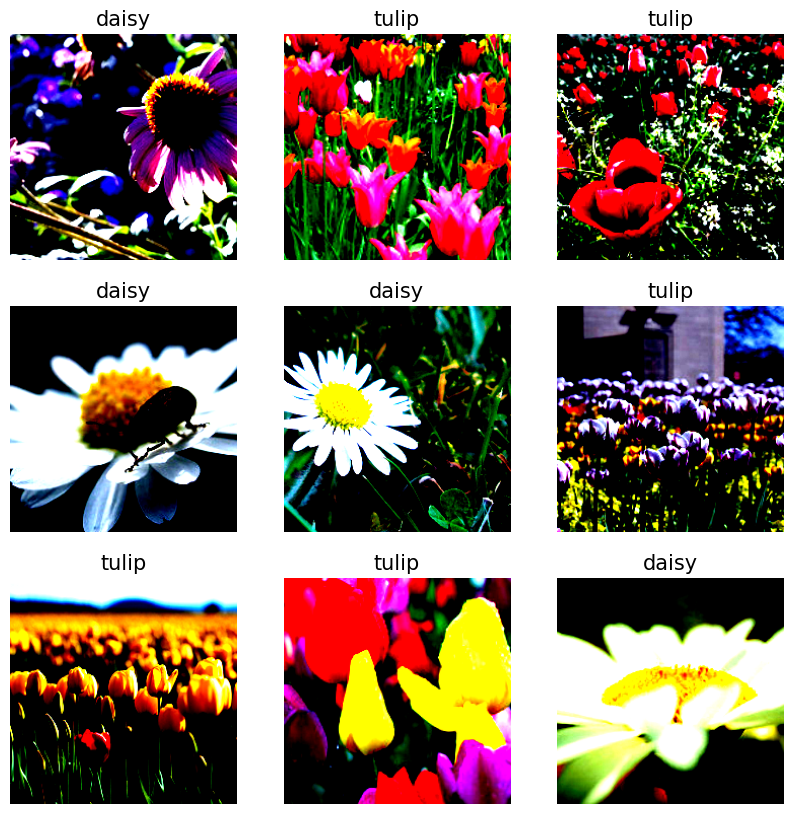

In [ ]:
# data exploration
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

for ax in axs.reshape(-1):
    idx = np.random.randint(600)
    ax.set_title(classes[train_dataset[idx][1]], size=15)
    ax.axis('off')
    ax.imshow(train_dataset[idx][0].permute(1,2,0));

In [ ]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 600
    Root location: /content/drive/MyDrive/Advanced computer vision/Hiep/dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

# Alexnet

## Fetch pretrained model

In [ ]:
# load model with pretrained weights
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights='DEFAULT')
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 282MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Alexnet with SVM

In [ ]:
feature_extractor = model

feature_extractor.classifier = nn.Sequential(*list(feature_extractor.classifier.children())[:2])

feature_extractor = feature_extractor.to(device)

feature_extractor.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Training & evaluation Alexnet with SVM


In [ ]:
def predict(feature_extractor, clf, data):
  data = data.to(device)

  features = feature_extractor(data)
  features_np = features.cpu().detach().numpy()


  preds = clf.predict(features_np)

  return preds

In [ ]:
def evaluate(feature_extractor, clf, data_loader):
  scores = []
  y = []
  t = []

  for batch_idx, (data, targets) in enumerate(data_loader):
    preds = predict(feature_extractor, clf, data)

    targets_np = targets.numpy()

    y = np.concatenate((y, targets_np))
    t = np.concatenate((t, preds))

  # confusion matrix
  cm = confusion_matrix(t, y)

  ConfusionMatrixDisplay(cm).plot()

  t = torch.from_numpy(t)
  y = torch.from_numpy(y)

  # accuracy
  acc = BinaryAccuracy()

  print(f'Accuracy: {acc(y, t):.2f}')

  # precision
  precision = BinaryPrecision()

  print(f'Precision: {precision(y, t):.2f}')

  # recall
  recall = BinaryRecall()

  print(f'Recall: {recall(y, t):.2f}')

  # f1s-score
  f1Score = BinaryF1Score()

  print(f'F1-score: {f1Score(y, t):.2f}')

In [ ]:
def train(feature_extractor, clf, train_loader, validate_loader):
  X = []
  y = []

  # features extracting
  for batch_idx, (data, targets) in enumerate(train_loader):
    data = data.to(device)

    features = feature_extractor(data)
    features_np = features.cpu().detach().numpy()
    targets_np = targets.numpy()

    if batch_idx == 0:
      X = features_np
    else:
      X = np.vstack((X, features_np))
    y = np.concatenate((y, targets_np))

  # fitting with svm
  clf.fit(X, y)

In [ ]:
clf = SVC()

train(feature_extractor, clf, train_loader, validate_loader)

Validation score: 
Accuracy: 0.96
Precision: 0.97
Recall: 0.96
F1-score: 0.97


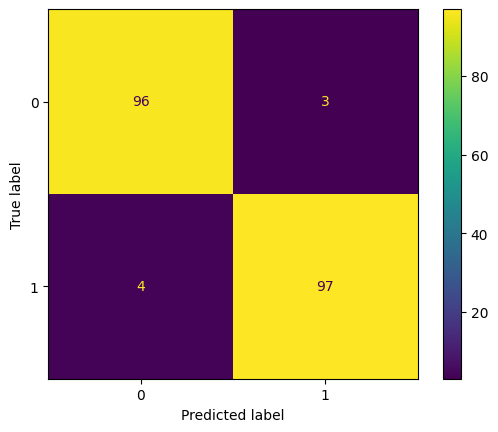

In [ ]:
print('Validation score: ')
evaluate(feature_extractor, clf, validate_loader)

Test score: 
Accuracy: 0.95
Precision: 0.94
Recall: 0.97
F1-score: 0.95


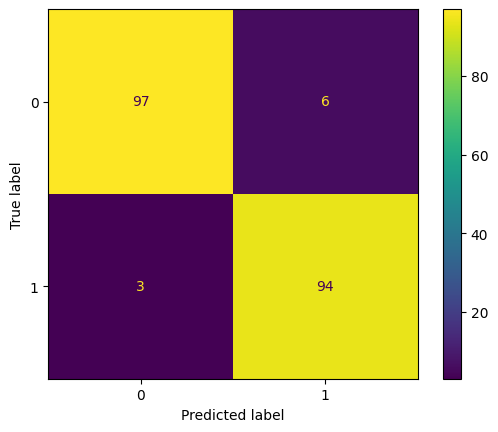

In [ ]:
print('Test score: ')
evaluate(feature_extractor, clf, test_loader)

## Alexnet with freezing convolutional layers


In [ ]:
# Modify model
model.classifier[6] = nn.Linear(4096, 1)
model.classifier.append(nn.Sigmoid())

model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Training & evaluation 2 last layers of alexnet


In [ ]:
def train(model, train_loader, validate_loader, num_epochs, optimizer, criterion):
  loss_each_batch = []

  for epoch in range(num_epochs):
    # training
    model.train(True)
    train_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
      targets = np.reshape(targets, (-1, 1))

      data = data.to(device)
      targets = targets.to(device)

      # forward pass
      scores = model(data)
      loss = criterion(scores, targets.float())

      # backward pass
      optimizer.zero_grad()
      loss.backward()

      # gradient descent
      optimizer.step()
      train_loss += loss.item()
      loss_each_batch.append(loss.item())

      if batch_idx % 3 == 0:
        print(f'Epoch {epoch+1} | Batch: {batch_idx+1} | Training Loss: {loss.item() / len(train_loader)*1.0:.4f}')

    # evaluation
    num_samples = 0
    num_correct = 0
    model.train(False)
    val_loss = 0.0
    for batch_idx, (data, targets) in enumerate(validate_loader):
      targets = np.reshape(targets, (-1, 1))

      data = data.to(device)
      targets = targets.to(device)

      # forward pass
      scores = model(data)
      loss = criterion(scores, targets.float())


      val_loss += loss.item()
      num_correct += (scores.round() == targets).sum()
      num_samples += scores.size(0)

    print(f'** Epoch {epoch+1} | Training Loss: {train_loss / len(train_loader)*1.0:.2f} | Validation Loss: {val_loss / len(validate_loader)*1.0:.2f} | Validation Accuracy: {float(num_correct)/float(num_samples)*100.0:.2f}')
  return loss_each_batch

In [ ]:
def freeze_conv_layers(model, lr):
  layer_lr = [{'params': model.features.parameters(), 'lr': 0}, # prevent weights of conv layers from changing by backpropagation
            {'params': model.avgpool.parameters(), 'lr': lr},
            {'params': model.classifier.parameters(), 'lr': lr}]

  return layer_lr

In [ ]:
# Hyperparameters
lr = 0.00008
num_epochs = 10

model = model.to(device)
criterion = nn.BCELoss()
model_params = freeze_conv_layers(model, lr)
optimizer = optim.Adam(model_params, lr=lr)
loss_cache = train(model, train_loader, validate_loader, num_epochs, optimizer, criterion)

Epoch 1 | Batch: 1 | Training Loss: 0.0559
Epoch 1 | Batch: 4 | Training Loss: 0.0192
Epoch 1 | Batch: 7 | Training Loss: 0.0084
Epoch 1 | Batch: 10 | Training Loss: 0.0084
Epoch 1 | Batch: 13 | Training Loss: 0.0044
Epoch 1 | Batch: 16 | Training Loss: 0.0042
Epoch 1 | Batch: 19 | Training Loss: 0.0109
** Epoch 1 | Training Loss: 0.26 | Validation Loss: 0.09 | Validation Accuracy: 96.00
Epoch 2 | Batch: 1 | Training Loss: 0.0006
Epoch 2 | Batch: 4 | Training Loss: 0.0012
Epoch 2 | Batch: 7 | Training Loss: 0.0017
Epoch 2 | Batch: 10 | Training Loss: 0.0009
Epoch 2 | Batch: 13 | Training Loss: 0.0016
Epoch 2 | Batch: 16 | Training Loss: 0.0013
Epoch 2 | Batch: 19 | Training Loss: 0.0005
** Epoch 2 | Training Loss: 0.04 | Validation Loss: 0.08 | Validation Accuracy: 96.50
Epoch 3 | Batch: 1 | Training Loss: 0.0006
Epoch 3 | Batch: 4 | Training Loss: 0.0004
Epoch 3 | Batch: 7 | Training Loss: 0.0012
Epoch 3 | Batch: 10 | Training Loss: 0.0006
Epoch 3 | Batch: 13 | Training Loss: 0.0006
E

In [ ]:
def plot_loss_history(loss_cache):
  plt.grid()
  plt.plot(loss_cache)

  plt.ylabel('Loss', fontsize=20)
  plt.xlabel('Batch', fontsize=20)

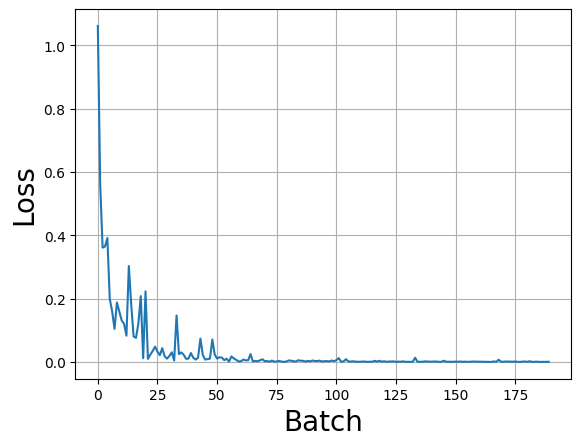

In [ ]:
plot_loss_history(loss_cache)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchmetrics.classification import *

def evaluate(loader, model):
  preds = torch.Tensor([]).to(device)
  targets = torch.Tensor([]).to(device)

  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)
      # forward
      scores = model(x)

      preds = torch.cat((preds, torch.reshape(scores, (-1,)).round()))
      targets = torch.cat((targets, y))
  model.train()

  # confusion matrix
  cm = confusion_matrix(targets.cpu(), preds.cpu())

  ConfusionMatrixDisplay(cm).plot()

  # accuracy
  acc = BinaryAccuracy().to(device)

  print(f'Accuracy: {acc(preds, targets):.2f}')

  # precision
  precision = BinaryPrecision().to(device)

  print(f'Precision: {precision(preds, targets):.2f}')

  # recall
  recall = BinaryRecall().to(device)

  print(f'Recall: {recall(preds, targets):.2f}')

  # f1s-score
  f1Score = BinaryF1Score().to(device)

  print(f'F1-score: {f1Score(preds, targets):.2f}')

Accuracy: 0.96
Precision: 0.98
Recall: 0.95
F1-score: 0.96


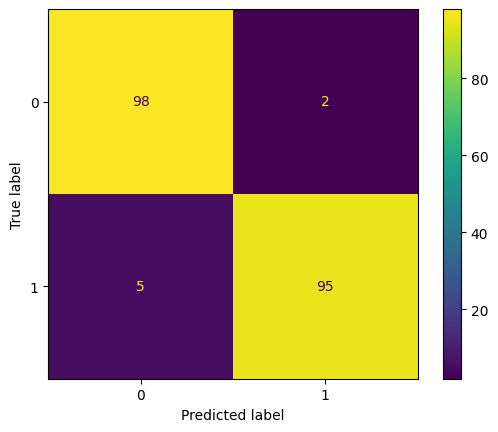

In [ ]:
evaluate(test_loader, model)

# VGG

## Fetch pretrained model

In [ ]:
# load model with pretrained weights
vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', weights='DEFAULT')
vgg.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 86.7MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Freezing conv layers

In [ ]:
# Modify model
vgg.classifier[6] = nn.Linear(4096, 1)
vgg.classifier.append(nn.Sigmoid())

vgg.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Training & evaluation vgg

In [ ]:
# Hyperparameters
lr = 0.00009
num_epochs = 10

vgg = vgg.to(device)
criterion = nn.BCELoss()
model_params = freeze_conv_layers(vgg, lr)
optimizer = optim.Adam(model_params, lr=lr)
loss_cache = train(vgg, train_loader, validate_loader, num_epochs, optimizer, criterion)

Epoch 1 | Batch: 1 | Training Loss: 0.0397
Epoch 1 | Batch: 4 | Training Loss: 0.0153
Epoch 1 | Batch: 7 | Training Loss: 0.0055
Epoch 1 | Batch: 10 | Training Loss: 0.0035
Epoch 1 | Batch: 13 | Training Loss: 0.0028
Epoch 1 | Batch: 16 | Training Loss: 0.0048
Epoch 1 | Batch: 19 | Training Loss: 0.0005
** Epoch 1 | Training Loss: 0.20 | Validation Loss: 0.07 | Validation Accuracy: 96.50
Epoch 2 | Batch: 1 | Training Loss: 0.0015
Epoch 2 | Batch: 4 | Training Loss: 0.0013
Epoch 2 | Batch: 7 | Training Loss: 0.0003
Epoch 2 | Batch: 10 | Training Loss: 0.0018
Epoch 2 | Batch: 13 | Training Loss: 0.0011
Epoch 2 | Batch: 16 | Training Loss: 0.0002
Epoch 2 | Batch: 19 | Training Loss: 0.0000
** Epoch 2 | Training Loss: 0.01 | Validation Loss: 0.05 | Validation Accuracy: 97.00
Epoch 3 | Batch: 1 | Training Loss: 0.0000
Epoch 3 | Batch: 4 | Training Loss: 0.0001
Epoch 3 | Batch: 7 | Training Loss: 0.0000
Epoch 3 | Batch: 10 | Training Loss: 0.0000
Epoch 3 | Batch: 13 | Training Loss: 0.0000
E

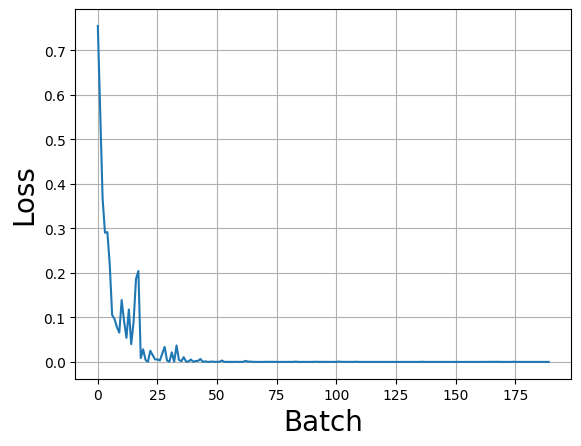

In [ ]:
plot_loss_history(loss_cache)

Accuracy: 0.99
Precision: 0.98
Recall: 1.00
F1-score: 0.99


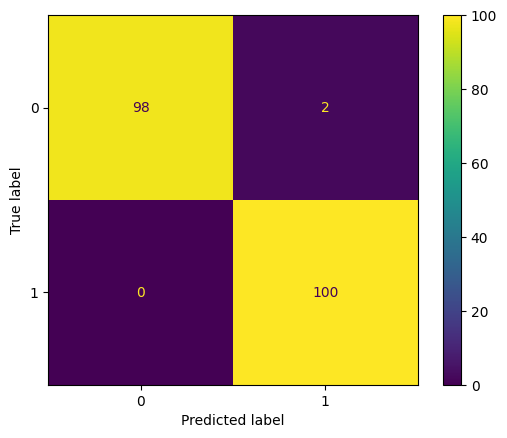

In [ ]:
evaluate(test_loader, vgg)